94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5108 - loss: 1.7944 - val_accuracy: 0.9312 - val_loss: 0.2414
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9631 - loss: 0.1375 - val_accuracy: 0.9625 - val_loss: 0.1092
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9899 - loss: 0.0538 - val_accuracy: 0.9812 - val_loss: 0.0767
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9961 - loss: 0.0341 - val_accuracy: 0.9906 - val_loss: 0.0552
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 1.0000 - loss: 0.0186 - val_accuracy: 0.9906 - val_loss: 0.0430
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9906 - val_loss: 0.0385
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9812 - val_loss: 0.0510
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 1.00

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step - accuracy: 0.9944 - loss: 0.0178
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 886ms/step


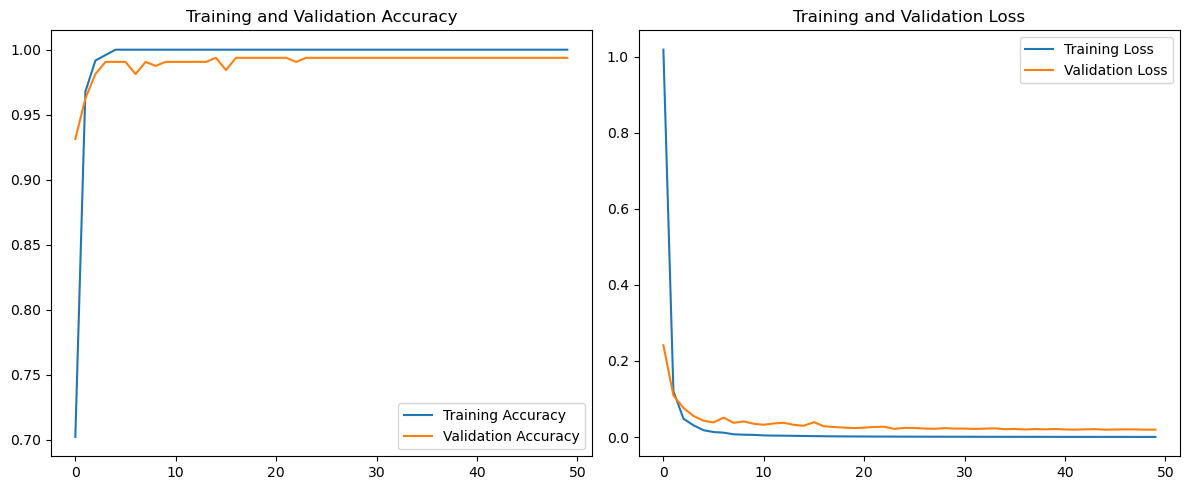

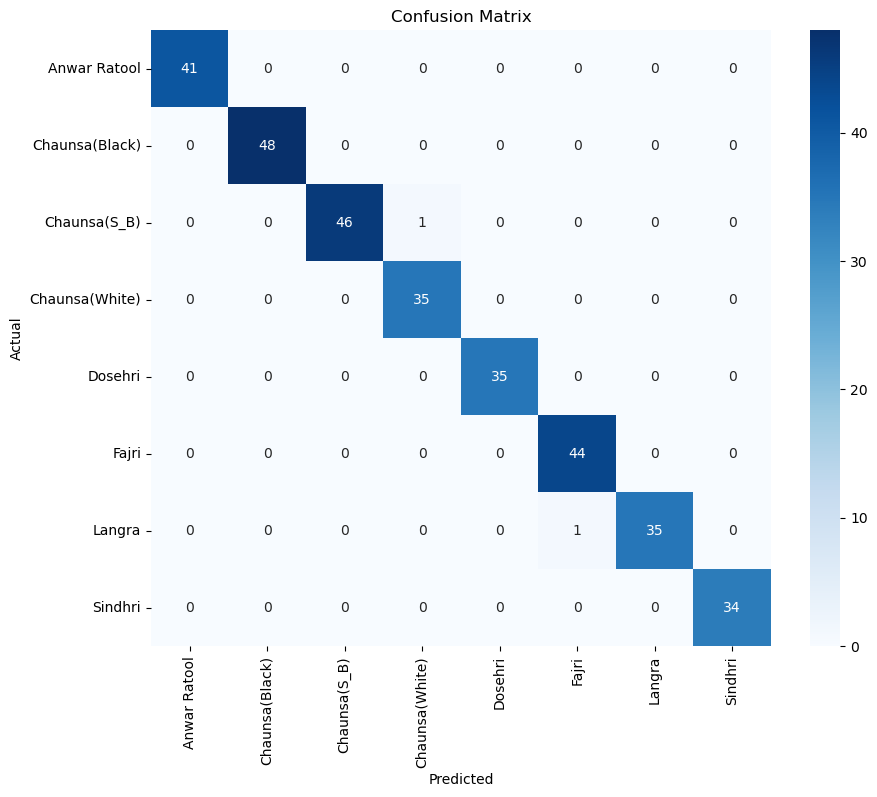

Model saved to F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_transfer_learning_model.h5
Training history saved to F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_training_history.xlsx
Metrics saved to F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_model_metrics.xlsx


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
)
import seaborn as sns
import pandas as pd

# Initialize memory tracking
tracemalloc.start()

# Load and preprocess images
image_paths = []
labels = []

root_dir = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
for label in os.listdir(root_dir):
    label_dir = os.path.join(root_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            if filename.endswith(".jpg"):
                image_paths.append(os.path.join(label_dir, filename))
                labels.append(label)

# Load images into arrays
images = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(224, 224))  # ResNet50 uses 224x224 input size
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    images.append(img_array)

X = np.array(images)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split dataset into train, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Build transfer learning model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train model and measure time
start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=32)
training_time = time.time() - start_time

# Save the trained model
model_path = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_transfer_learning_model.h5'
save_model(model, model_path)

# Save training history
history_df = pd.DataFrame(history.history)
history_path = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_training_history.xlsx'
history_df.to_excel(history_path, index=False)

# Evaluate on test set
start_time = time.time()
test_loss, test_acc = model.evaluate(X_test, y_test)
evaluation_time = time.time() - start_time

# Predictions and metrics
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = (time.time() - start_time) / len(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
test_log_loss = log_loss(y_test, y_pred)

# Compute confusion matrix and class-wise accuracy
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)  # Per-class accuracy

# Convert class-wise accuracy to a DataFrame
class_accuracy_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Accuracy': class_wise_accuracy
})

# Memory usage
current, peak = tracemalloc.get_traced_memory()
memory_usage = peak / (1024 ** 2)  # Convert to MB
tracemalloc.stop()

# Save metrics to Excel
metrics_data = {
    'Training Accuracy': history.history['accuracy'][-1],
    'Validation Accuracy': history.history['val_accuracy'][-1],
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Log Loss': test_log_loss,
    'Training Time (s)': training_time,
    'Inference Time (s/img)': inference_time,
    'Peak Memory Usage (MB)': memory_usage
}

metrics_df = pd.DataFrame([metrics_data])

# Save confusion matrix and class-wise accuracy to Excel
metrics_path = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_model_metrics.xlsx'
with pd.ExcelWriter(metrics_path) as writer:
    metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
    class_accuracy_df.to_excel(writer, sheet_name="Class Accuracy", index=False)
    pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_).to_excel(writer, sheet_name="Confusion Matrix")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ResNet50_training_history.png', dpi=300)
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\confusion_matrix.png', dpi=300)
plt.show()

print(f"Model saved to {model_path}")
print(f"Training history saved to {history_path}")
print(f"Metrics saved to {metrics_path}")
